In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [21]:
sns.set_context('talk')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [43]:
sim_name = 'test_schedule_v3'
os.mkdir(f'fig/{sim_name}')

In [2]:
%run ../bin/analyze_sim.py test_schedule_v3

/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Simulation Name	test_schedule_v3
Number of Nights	362
Nights completely weathered out	88
Average Hours of Darkness	9.940953265617141
Total Science Time (h)	2128.6487659949603
Average Science Time per night (h)	5.8802452099308296
Fraction of time usable	0.5915172371113425
Average Number of Exposures per hour	82.1431899866631
Open Shutter Fraction	0.6836472678107662
Mean Time Between Exposures (s)	13.882278789862736
Mean Slew Distance (deg)	8.973081537112204
90% Time Between Exposures (s)	16.336994916386903
90% Slew Distance (deg)	14.76749899154009
Median Airmass	1.0970940709278831
90% Airmass	1.5227533440322685
Program Fraction	{1: 0.40372539375707733, 2: 0.39464353117457995, 3: 0.20163107506834274}
Filter Fraction	{'g': 0.29943838859848787, 'i': 0.031923776407745894, 'r': 0.66863783499376628}
Average Nightly Filter Exchanges	8.64963503649635
Average Filter Exchanges per hour	1.1133823662506523
Sequence Completion Fraction by Program	{1: 0.89379775280898877, 2: 0.82678344635882195, 3: 0

In [3]:
df = df_read_from_sqlite('test_schedule_v3', tablename='Summary', directory='sims')

In [4]:
df.columns

Index(['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'finRank', 'FWHMgeom', 'FWHMeff', 'transparency', 'airmass',
       'vSkyBright', 'filtSkyBright', 'rotSkyPos', 'rotTelPos', 'lst',
       'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec',
       'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle',
       'rScatter', 'mieScatter', 'moonBright', 'darkBright', 'rawSeeing',
       'wind', 'humidity', 'slewDist', 'slewTime', 'fiveSigmaDepth',
       'ditheredRA', 'ditheredDec', 'totalRequestsTonight', 'metricValue'],
      dtype='object')

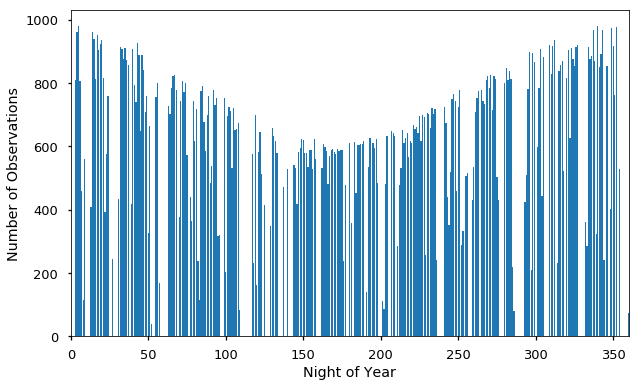

In [44]:
grp_night = df.groupby('night')
nobs_night = grp_night['expDate'].agg(len)
plt.bar(nobs_night.index, nobs_night.values)
plt.xlabel('Night of Year')
plt.ylabel('Number of Observations')
plt.xlim(0,360)
plt.savefig(f'fig/{sim_name}/nobs_bynight.png')

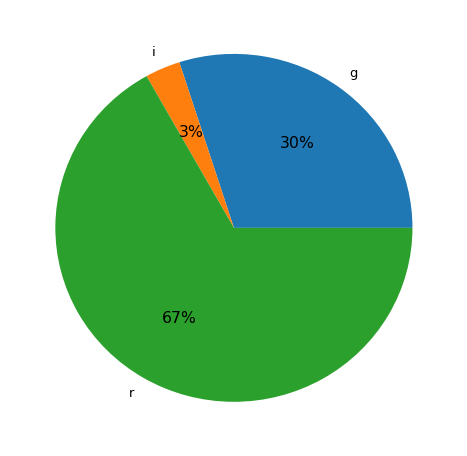

In [45]:
plt.figure(figsize=(8,8))
grp_filter = df.groupby('filter')
nobs_perfilter = grp_filter['expDate'].agg(len)
plt.pie(nobs_perfilter, labels=nobs_perfilter.index, autopct='%.0f%%')
plt.savefig(f'fig/{sim_name}/nobs_byfilter.png')

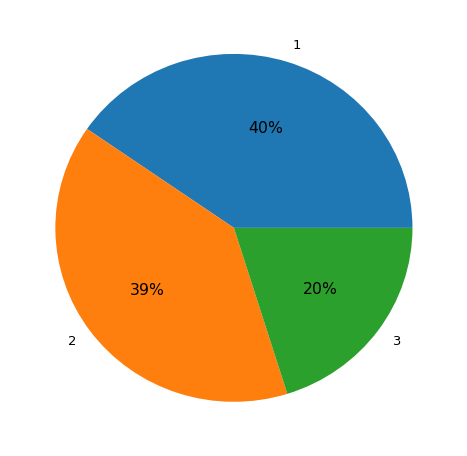

In [48]:
plt.figure(figsize=(8,8))
grp_program = df.groupby('propID')
nobs_perprogram = grp_program['expDate'].agg(len)
plt.pie(nobs_perprogram, labels=nobs_perprogram.index, autopct='%.0f%%')
plt.savefig(f'fig/{sim_name}/nobs_byprogram.png')

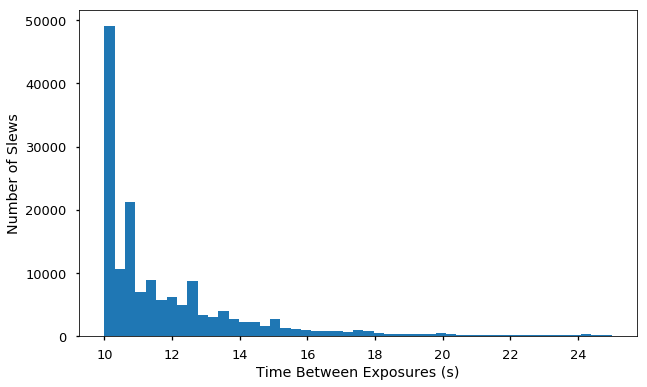

In [60]:
plt.hist(df.loc[df.slewTime.notnull(),'slewTime'],bins=np.linspace(10,25,50))
plt.xlabel('Time Between Exposures (s)')
plt.ylabel('Number of Slews')
plt.savefig(f'fig/{sim_name}/slew_time_hist.png')

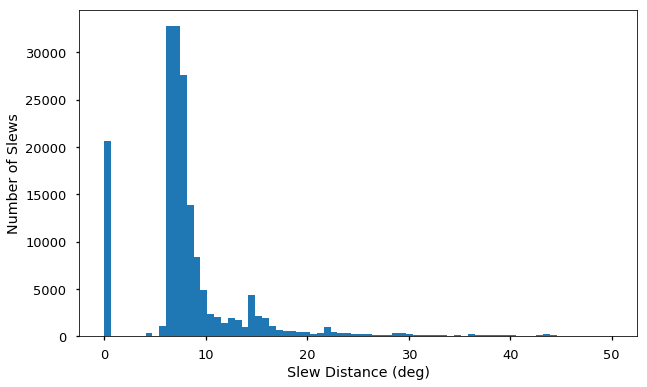

In [66]:
plt.hist(np.degrees(df.loc[df.slewTime.notnull(),'slewDist']),bins=np.linspace(0,50,75))
plt.xlabel('Slew Distance (deg)')
plt.ylabel('Number of Slews')
plt.savefig(f'fig/{sim_name}/slew_distance_hist.png')

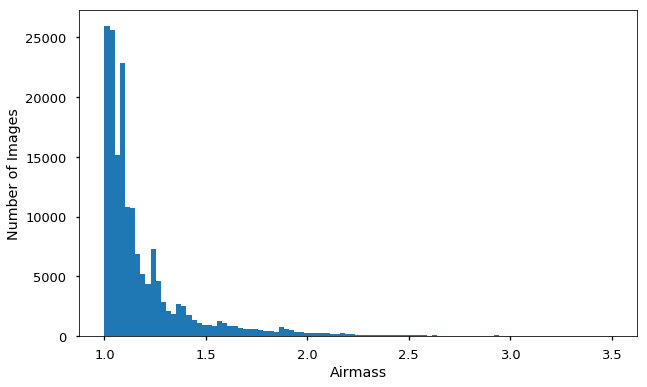

In [69]:
plt.hist(df.airmass,bins=np.linspace(1,3.5,100))
plt.xlabel('Airmass')
plt.ylabel('Number of Images')
plt.savefig(f'fig/{sim_name}/airmass_hist.png')

In [73]:
intranight_grp = df.groupby(['night','propID','fieldID'])
intranight_gap = intranight_grp['expMJD'].agg(lambda x: np.median(np.diff(x)))

/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ebellm/anaconda3/envs/ztf_sim/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


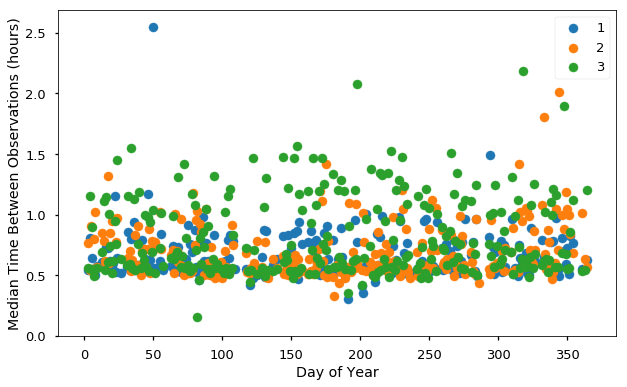

In [91]:
gap = intranight_gap['expMJD']*24.
gap = gap.reset_index()
grp_np = gap.groupby(['night','propID'])
intranight_gap_night_prop = grp_np.agg(np.median)
intranight_gap_night_prop = intranight_gap_night_prop.reset_index()
for prop in [1,2,3]:
    w = intranight_gap_night_prop['propID'] == prop
    plt.scatter(intranight_gap_night_prop.loc[w,'night'], intranight_gap_night_prop.loc[w,'expMJD'], label=prop)
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Median Time Between Observations (hours)')
plt.savefig(f'fig/{sim_name}/intranight_gap_by_doy.png')

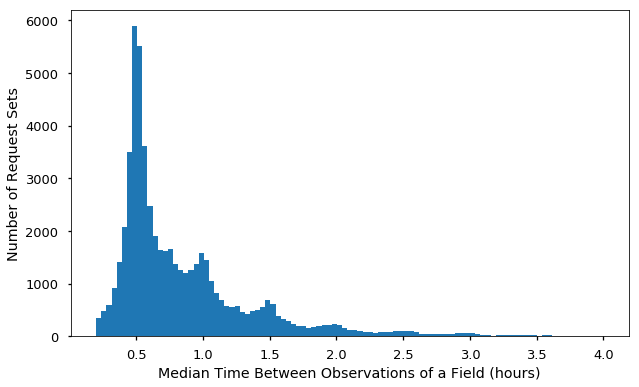

In [96]:
plt.hist(gap.loc[gap['expMJD'].notnull(),'expMJD'],bins=np.linspace(0.2,4,100))
plt.xlabel('Median Time Between Observations of a Field (hours)')
plt.ylabel('Number of Request Sets')
plt.savefig(f'fig/{sim_name}/intranight_gap_hist.png')

In [99]:
night_min = intranight_grp['expMJD'].agg(np.min)
night_max = intranight_grp['expMJD'].agg(np.max)
# not quite right--need to subtract night from night
#intranight_gap = night_max.values[:-1] - night_min.values[1:] 

In [98]:
intranight_gap

array([ 0.38366061, -0.00093006, -0.0004671 , ...,  0.12189336,
        0.05476746,  0.05663309])

In [109]:
night_min

night  propID  fieldID
3      1       475        57391.481084
               499        57391.161309
               500        57391.162239
               501        57391.162706
               502        57391.163178
               503        57391.147310
               504        57391.165542
               505        57391.166050
               506        57391.168985
               525        57391.477193
               527        57391.482018
               529        57391.486662
               550        57391.159911
               551        57391.160380
               552        57391.151082
               553        57391.149674
               554        57391.147773
               555        57391.187624
               556        57391.169959
               557        57391.252453
               558        57391.231971
               572        57391.395317
               573        57391.416236
               574        57391.436805
               575        57391.435875
  